# 20220327-zoo-stats
- Cumulative statistics (weighted over simpoints)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
    - DRAM bandwidth reduction (over no prefetcher)
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [150]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

from utils import utils, stats

from importlib import reload


In [151]:
data_path = '/u/cmolder/GitHub/Pythia/out/pythia_level.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

# Add SPEC / GAP results.
df = utils.read_data_file(data_path)
weights = utils.read_weights_file(weight_path)
weights

,full_trace,weight,trace,simpoint
0,astar_163B,0.452174,astar,163B
1,astar_23B,0.162319,astar,23B
2,astar_313B,0.220290,astar,313B
3,bwaves_1609B,0.262524,bwaves,1609B
4,bwaves_1861B,0.337187,bwaves,1861B
...,...,...,...,...
184,streaming_phase1_core3,0.166667,streaming_core3,phase1
185,streaming_phase2_core3,0.166667,streaming_core3,phase2
186,streaming_phase3_core3,0.166667,streaming_core3,phase3
187,streaming_phase4_core3,0.166666,streaming_core3,phase4


In [152]:
pd.set_option('display.max_rows', 100)
df[(df.trace == 'astar') & (df.pythia_level_threshold == -5.0)]

,full_trace,trace,simpoint,l1d_pref,l2c_pref,llc_pref,l2c_pref_degree,llc_pref_degree,pythia_level_threshold,accuracy,...,pythia_high_conf_prefetches,mpki,mpki_reduction,dram_bw_epochs,dram_bw_reduction,ipc,ipc_improvement,baseline_prefetcher,path,baseline_path
4,astar_313B,astar,313B,no,pythia,no,"(None,)","(None,)",-5.0,34.250786,...,1436985,31.56909,44.196439,3437931,11.029693,0.11603,12.661423,"('no', 'no', 'no')",/scratch/cluster/cmolder/pythia_level/exp_spec...,/scratch/cluster/cmolder/pythia_level/exp_spec...
20,astar_163B,astar,163B,no,pythia,no,"(None,)","(None,)",-5.0,18.070911,...,242868,0.68424,15.702846,750541,0.753728,0.56183,0.827321,"('no', 'no', 'no')",/scratch/cluster/cmolder/pythia_level/exp_spec...,/scratch/cluster/cmolder/pythia_level/exp_spec...
39,astar_23B,astar,23B,no,pythia,no,"(None,)","(None,)",-5.0,68.319632,...,52227,1.12676,57.102773,1360282,7.697141,0.30258,8.783031,"('no', 'no', 'no')",/scratch/cluster/cmolder/pythia_level/exp_spec...,/scratch/cluster/cmolder/pythia_level/exp_spec...


In [153]:
reload(utils)
reload(stats)

weighted_df = stats.get_weighted_statistics(df, weights) # Weighted by simpoint

---
## Metrics of each static threshold
- How does each static threshold compare to regular Pythia, and no prefetcher?

In [154]:
def plot_threshold_metric(wdf, trace, metric, dpi=192):
    wdf = wdf[wdf.trace == trace]#[['pythia_level_threshold', metric]])
    wdf = wdf.sort_values('pythia_level_threshold')
    X, y = wdf.pythia_level_threshold.to_numpy(), wdf[metric].to_numpy()
    
    
    fig, ax = plt.subplots(dpi=dpi)
    
    
    ax.plot(np.arange(0, len(y)), y)
    
    ax.set_xticks(np.arange(0, len(y)))
    ax.set_xticklabels(['Regular' if x == float('-inf') else str(x) for x in X], rotation=45)
    ax.set_xlabel('Static level threshold')
    ax.set_ylabel(metric)
    #ax.set_ylim(ymin=0)
    
    plt.axhline(y=y[0], linewidth=0.75, ls='--', color='red') # Regular Pythia baseline
    #plt.axhline(y=0, linewidth=0.75, ls='--', color='black')  # No prefetcher baseline
    
    fig.suptitle(f'{trace} {metric}')
    plt.show()

## IPC improvement

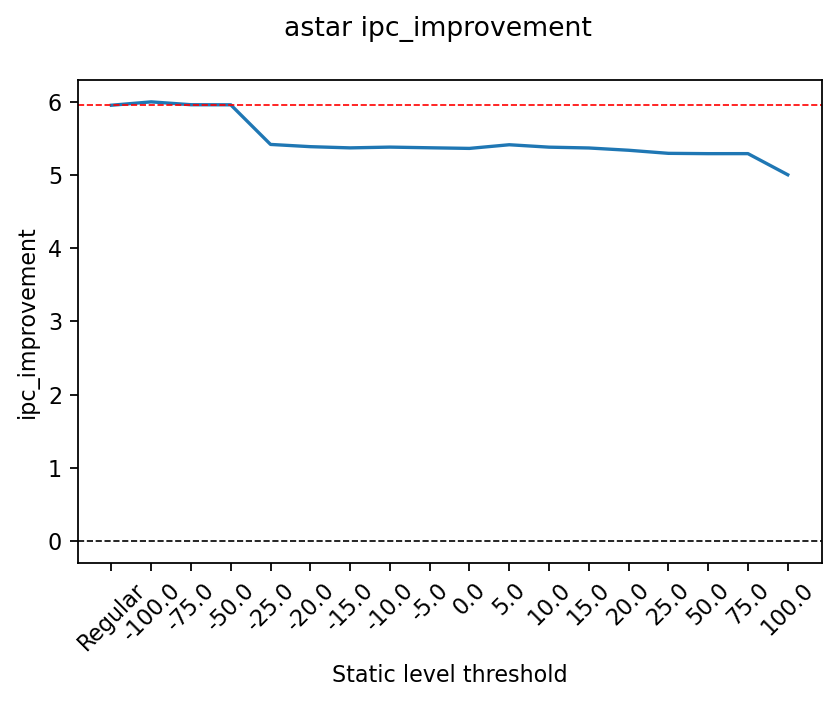

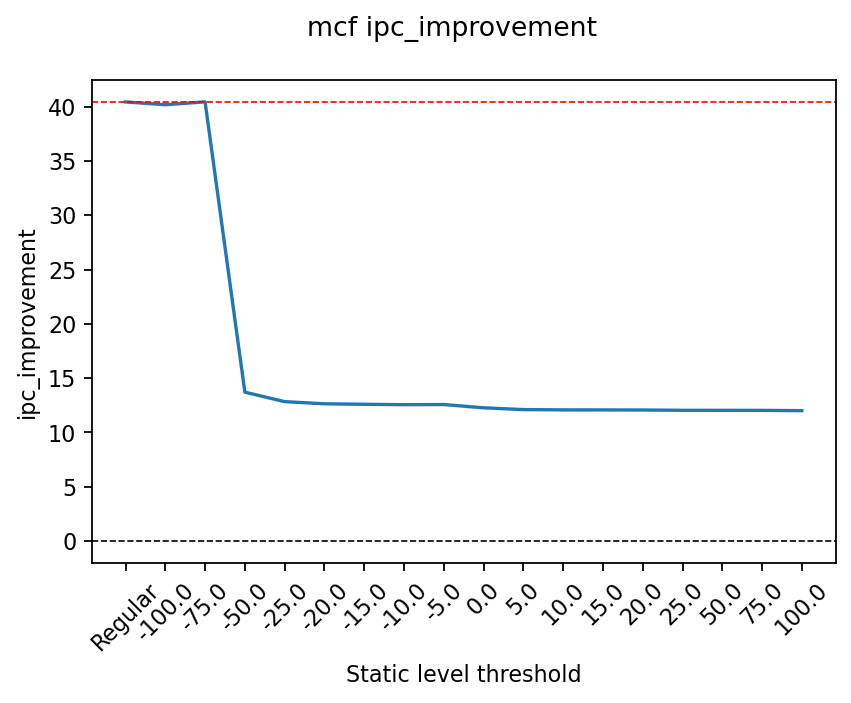

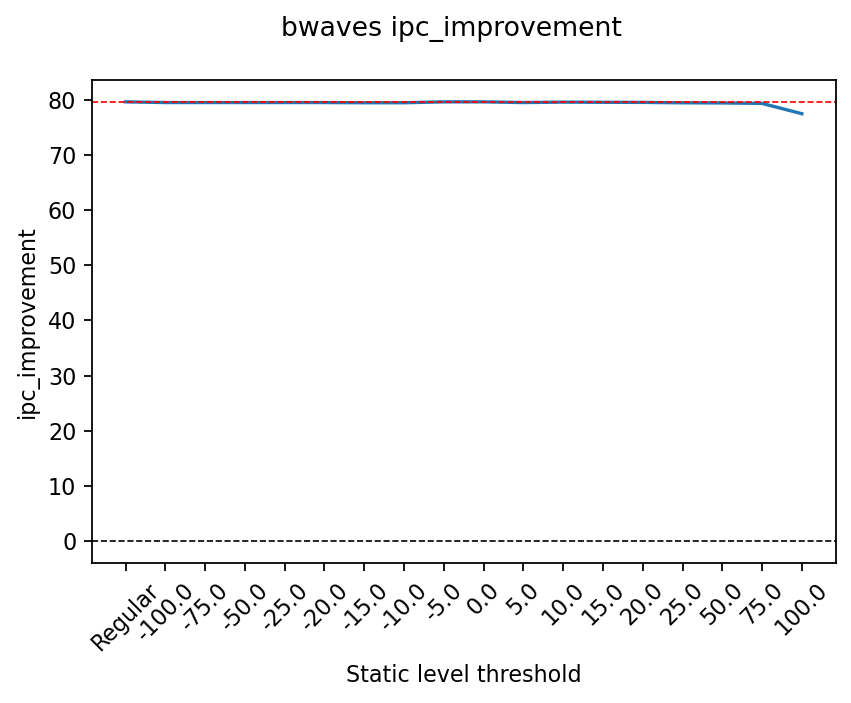

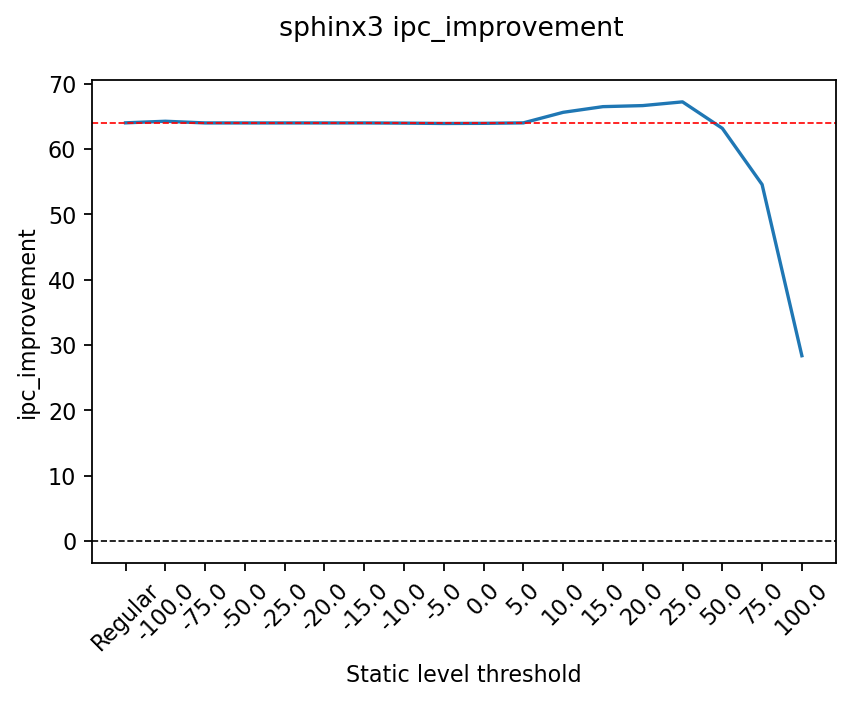

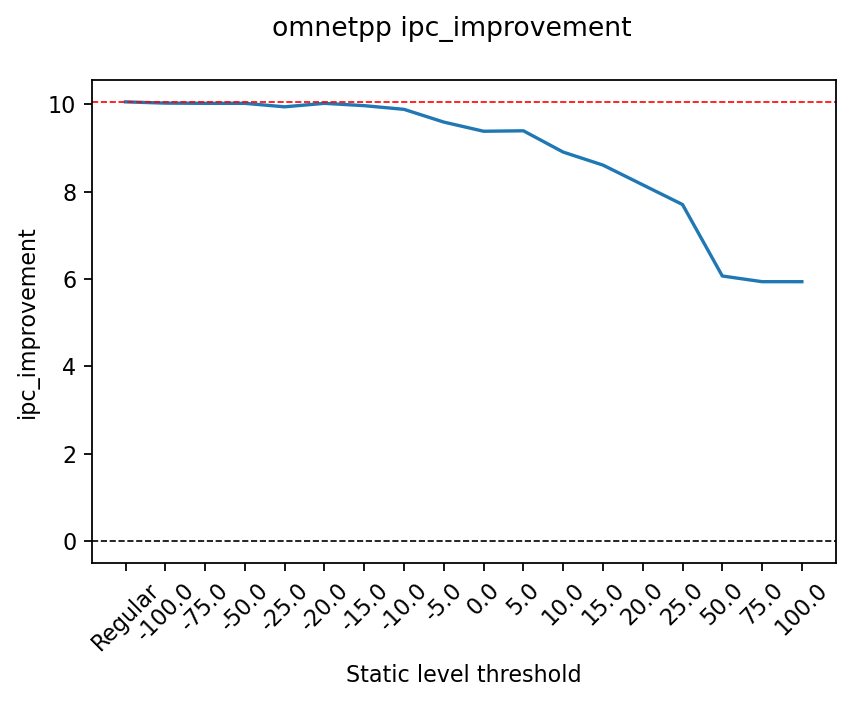

In [155]:
for tr in weighted_df.trace.unique():
    plot_threshold_metric(weighted_df, tr, 'ipc_improvement', dpi=160)

## LLC MPKI reduction

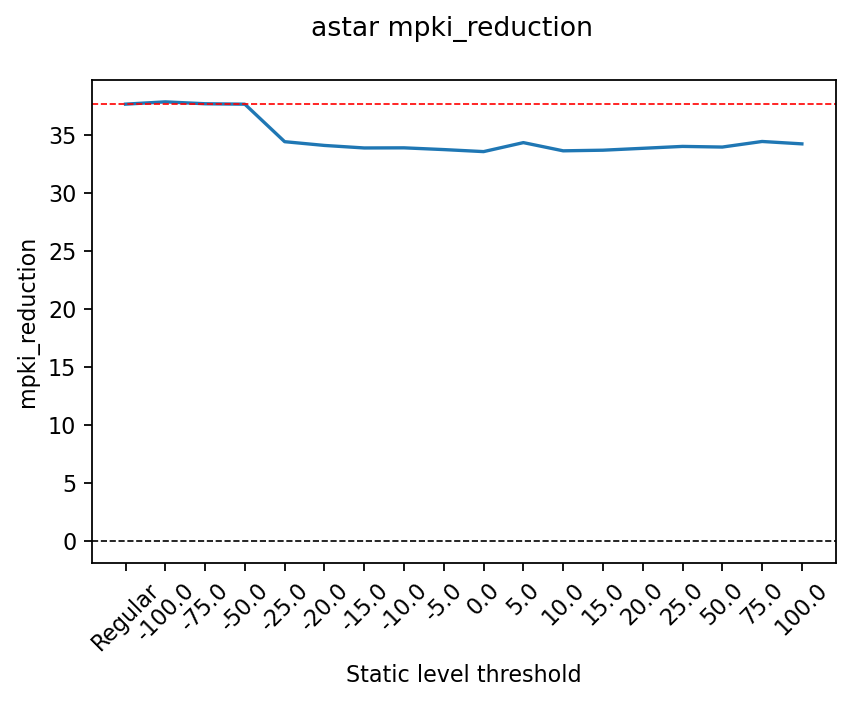

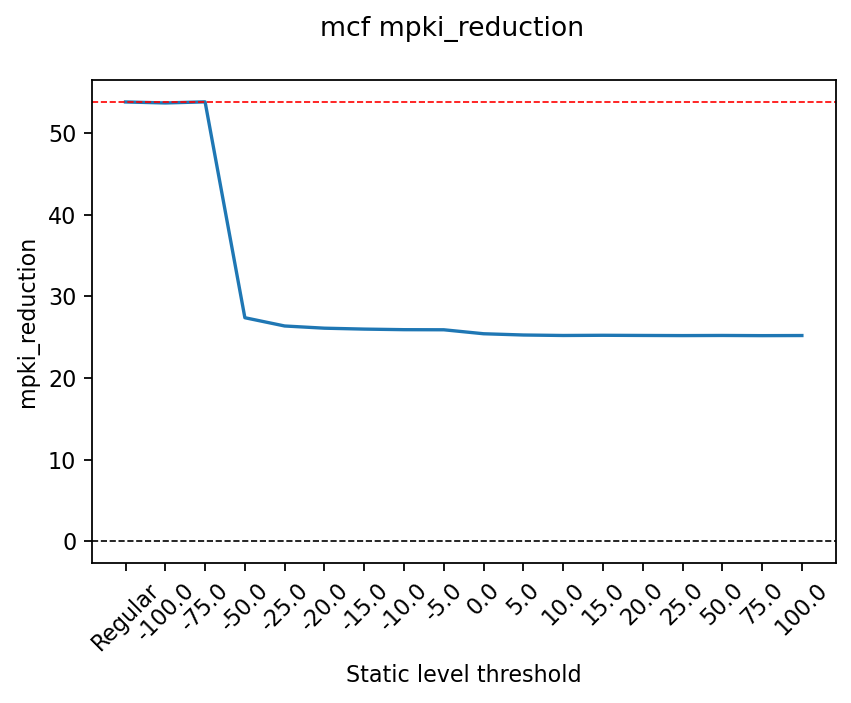

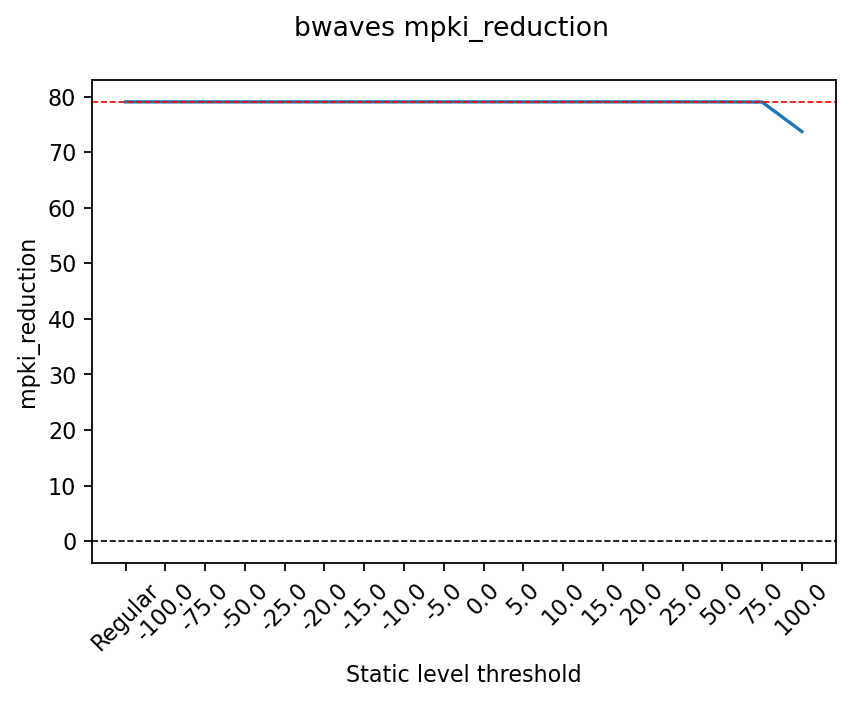

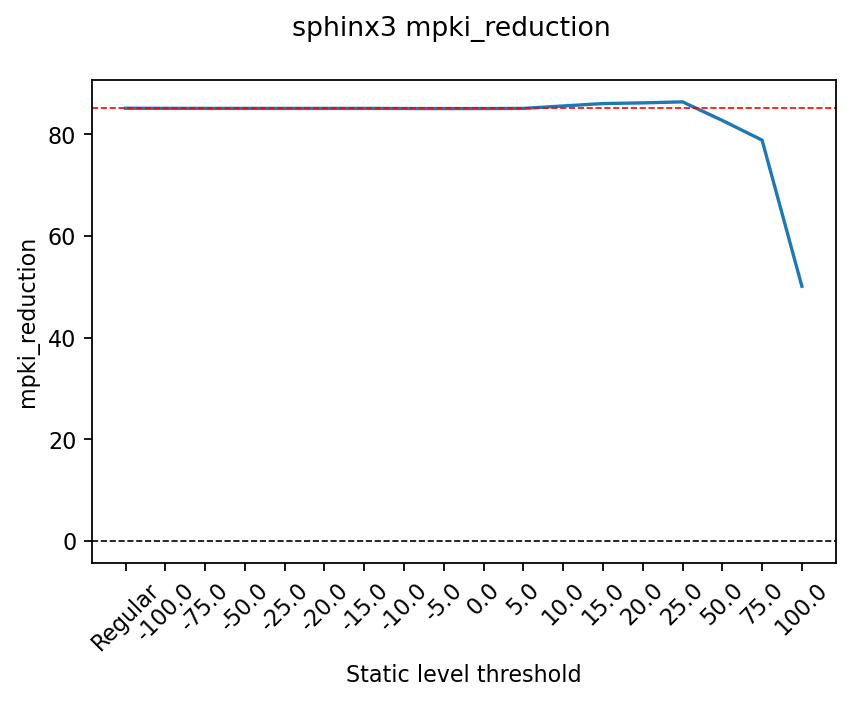

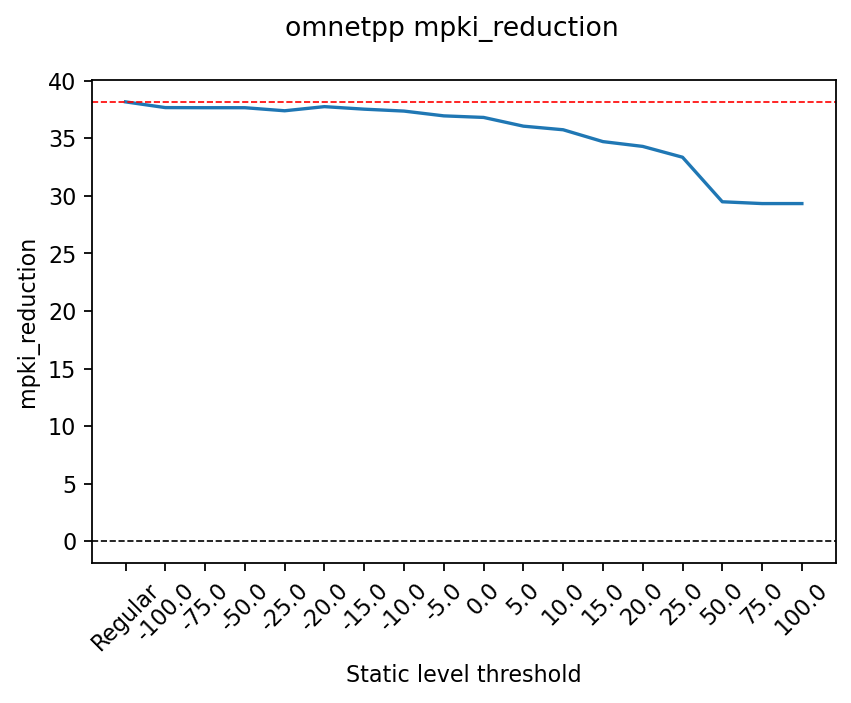

In [156]:
for tr in weighted_df.trace.unique():
    plot_threshold_metric(weighted_df, tr, 'mpki_reduction', dpi=160)